# Preparing the workspace

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from IPython.display import Video

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap  # For wrapping long titles

def visualize_kmeans_1d(num_points=20, 
                        x_low=0, x_high=100,
                        n_clusters=3, max_iters=10, 
                        seed=42, max_title_width=50):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_low, x_high, num_points)  # Generate random 1D points
    X = x[:, np.newaxis]  # Reshape to 2D array for K-means compatibility
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels, WCSS)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.abs(X - centroids.T)  # Use absolute difference for 1D distance
        labels = np.argmin(distances, axis=1)
        
        # Compute the WCSS for the current iteration
        wcss = sum((X - centroids[labels]) ** 2)
        
        # Save the current state (before updating centroids)
        states.append((iteration, centroids.copy(), labels.copy(), wcss))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep centroid if no points assigned
                
        # Check for convergence; if centroids don't change, stop early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            # Save the final state
            states.append((iteration + 1, centroids.copy(), labels.copy(), wcss))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Visualization: Plot 1D clustering for each iteration ----
    num_states = len(states) + 1  # +1 for the initial scatter plot
    fig, axes = plt.subplots(num_states, 1, figsize=(10, 3 * num_states))
    
    if num_states == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot

    cmap = plt.get_cmap("Set1")  # Colormap for consistent cluster colors

    # ---- First Plot: Initial scatter plot ----
    ax = axes[0]
    ax.scatter(X.flatten(), np.zeros_like(X), color='gray', alpha=0.6, edgecolor='k', label='Data points')
    ax.set_xlim(x_low, x_high)
    ax.set_yticks([])  # Hide y-axis since it's 1D
    ax.set_title("Initial distribution")
    ax.set_xlabel("Data (1D)")
    ax.set_ylabel("")
    
    # ---- Remaining Plots: K-Means iterations ----
    for ax, (itr, centroids_state, labels_state, wcss) in zip(axes[1:], states):
        for k in range(n_clusters):
            # Plot points belonging to this cluster
            cluster_points = X[labels_state == k].flatten()
            ax.scatter(cluster_points, np.zeros_like(cluster_points),
                       color=cmap(k), alpha=0.6, edgecolor='k', label=f"Cluster {k}")
            # Plot centroid
            ax.scatter(centroids_state[k], 0, color=cmap(k), marker='X', s=200, edgecolors='k', linewidth=1.5, label=f"Centroid {k}")
        
        # Construct counts for each cluster
        counts_str = ", ".join([f"$C_{k}$: {np.sum(labels_state == k)}"
                                for k in range(n_clusters)])
        
        # Wrap the title to a maximum width using textwrap
        raw_title = f"$I_{itr}$: {counts_str}\nWCSS: {wcss[0]:.2f}"
        wrapped_title = "\n".join(textwrap.wrap(raw_title, width=max_title_width))
        
        ax.set_title(wrapped_title, fontsize=10)
        ax.set_xlim(x_low, x_high)
        ax.set_yticks([])
        ax.set_xlabel("Data (1D)")
        ax.set_ylabel("")
        ax.grid(True)

    
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_kmeans_1d(num_points=30, n_clusters=5, max_iters=10, seed=42, max_title_width=60)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import textwrap  # For wrapping long titles

def visualize_kmeans_step_by_step(num_points=10, 
                                  x_low=0, x_high=30,
                                  y_low=0, y_high=30,
                                  n_clusters=3, max_iters=10, 
                                  seed=42, max_title_width=50):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_low, x_high, num_points)
    y = rng.uniform(y_low, y_high, num_points)
    X = np.column_stack((x, y))
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels, WCSS)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid using Euclidean distance
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute the WCSS for the current iteration
        wcss = sum(np.min(distances, axis=1) ** 2)
        
        # Save the current state (before updating centroids)
        states.append((iteration, centroids.copy(), labels.copy(), wcss))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # If no points assigned, keep the old centroid
                
        # Check for convergence; if converged, store final state and break early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            # Recompute WCSS for the final state
            distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
            wcss = sum(np.min(distances, axis=1) ** 2)
            states.append((iteration + 1, centroids.copy(), labels.copy(), wcss))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Visualization: Plot each iteration in subplots ----
    num_states = len(states) + 1  # +1 for the initial scatter plot
    nrows = math.ceil(math.sqrt(num_states))
    ncols = math.ceil(num_states / nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)
    
    cmap = plt.get_cmap("Set1")  # Qualitative colormap for consistent cluster colors

    # ---- First Subplot: Initial scatter plot with gray points and colored centroids ----
    ax = axes[0]
    ax.scatter(x, y, color='gray', alpha=0.6, edgecolor='k')
    for k in range(n_clusters):
        ax.scatter(centroids[k, 0], centroids[k, 1],
                   color=cmap(k), marker='X', s=200, edgecolors='k', linewidth=1.5)
    ax.set_title("Initial distribution with centroids")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    
    # ---- Remaining Subplots: K-Means iterations ----
    for ax, (itr, centroids_state, labels_state, wcss) in zip(axes[1:], states):
        for k in range(n_clusters):
            # Plot cluster points using their respective colors
            cluster_points = X[labels_state == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                       color=cmap(k), alpha=0.6, edgecolors='k')
            ax.scatter(centroids_state[k, 0], centroids_state[k, 1],
                       color=cmap(k), marker='X', s=200, edgecolors='k', linewidth=1.5)
        
        # Construct counts for each cluster in this iteration
        counts_str = ", ".join([f"$C_{k}$: {np.sum(labels_state == k)}"
                                for k in range(n_clusters)])
        
        # Wrap the title to a maximum width using textwrap
        raw_title = f"{counts_str}\nWCSS: {wcss:.2f}"
        wrapped_title = "\n".join(textwrap.wrap(raw_title, width=max_title_width))
        
        ax.set_title(wrapped_title, fontsize=10)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
    
    # Turn off any unused subplots in the grid
    for i in range(num_states, len(axes)):
        axes[i].axis('off')
    
    # Adjust layout to leave room at the bottom for the summary text.
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    
    # Combine summary lines into a single string
    summary_lines = [f"$I_{itr}$: {', '.join([f'Cluster {k}: {np.sum(labels_state == k)}' for k in range(n_clusters)])}, WCSS: {wcss:.2f}" 
                     for itr, _, labels_state, wcss in states]
    summary_text = "\n".join(summary_lines)
    
    # Print summary text below the subplots
    fig.text(0.5, 0.05, summary_text, ha="center", va="center", fontsize=10)
    
    # Setting a suptitle if desired
    fig.suptitle("K-Means Iterations Summary", fontsize=14, y=0.98)
    
    plt.show()

# Example usage:
# visualize_kmeans_step_by_step(num_points=100, n_clusters=5, max_iters=10, seed=42, max_title_width=40)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_kmeans_2d(num_points=50, 
                      x_low=0, x_high=300,
                      y_low=0, y_high=300,
                      n_clusters=3, max_iters = 10, 
                      seed=42, output_filename="kmeans_2d_animation.mp4", fps=15):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_low, x_high, num_points)
    y = rng.uniform(y_low, y_high, num_points)
    X = np.column_stack((x, y))  # Combine into 2D coordinates
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Save the current state (before updating centroids)
        states.append((centroids.copy(), labels.copy()))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep centroid if no points assigned
                
        # Check for convergence; if centroids don't change, stop early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            states.append((centroids.copy(), labels.copy()))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Interpolation for Smooth Animation ----
    interpolated_states = []
    for i in range(len(states) - 1):
        centroids_start, labels_start = states[i]
        centroids_end, labels_end = states[i + 1]
        
        # Add intermediate frames by interpolating centroid positions
        steps = fps // 2  # Number of interpolation steps between frames
        for alpha in np.linspace(0, 1, steps):
            interpolated_centroids = (1 - alpha) * centroids_start + alpha * centroids_end
            interpolated_states.append((interpolated_centroids, labels_start))
    interpolated_states.append(states[-1])  # Add the last state

    # ---- Animation Setup ----
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap("Set1")  # Colormap for consistent cluster colors

    def init():
        """Initialize the animation by clearing the axes."""
        ax.clear()
        ax.set_xlim(x_low, x_high)
        ax.set_ylim(y_low, y_high)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_title("2D K-Means Animation")
        return []

    def update(frame):
        """Update the animation frame with the new state."""
        centroids_state, labels_state = interpolated_states[frame]
        ax.clear()
        ax.set_xlim(x_low, x_high)
        ax.set_ylim(y_low, y_high)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_title(f"Iteration {frame // (fps // 2) + 1}")
        
        # Plot each cluster and its centroid
        for k in range(n_clusters):
            cluster_points = X[labels_state == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=f"C{k}", alpha=0.6, label=f"Cluster {k}")
            ax.scatter(centroids_state[k, 0], centroids_state[k, 1], color=f"C{k}", marker="X", s=200, edgecolor="k")

    ani = FuncAnimation(fig, update, frames=len(interpolated_states), init_func=init, blit=False, repeat=True)

    # Save the animation to a file
    ani.save(output_filename, writer='ffmpeg', fps=fps)
    print(f"Animation saved as {output_filename}")

# Example usage in Kaggle or other environments:
# animate_kmeans_2d(num_points=500, n_clusters=4, max_iters=10, seed=42, output_filename="kmeans_2d_animation.mp4", fps=30)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

def engaging_animate_kmeans_2d(num_points=50, 
                               n_clusters=3, max_iters=10, 
                               seed=42, output_filename="engaging_kmeans_2d.mp4", fps=15,
                               data_type="uniform",  # Options: "uniform", "blobs"
                               blob_std=1.5):  # Only used if data_type="blobs"
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    if data_type == "uniform":
        x = rng.uniform(0, 100, num_points)
        y = rng.uniform(0, 100, num_points)
        X = np.column_stack((x, y))  # Combine into 2D coordinates
    elif data_type == "blobs":
        X, _ = make_blobs(n_samples=num_points, centers=n_clusters, cluster_std=blob_std, random_state=seed)
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels, WCSS, Silhouette Score)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute WCSS for the current iteration
        wcss = sum(np.min(distances, axis=1) ** 2)
        
        # Compute Silhouette Score (only if there are more than 1 cluster)
        silhouette = silhouette_score(X, labels) if n_clusters > 1 else 0
        
        # Save the current state (before updating centroids)
        states.append((centroids.copy(), labels.copy(), wcss, silhouette))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep centroid if no points assigned
                
        # Check for convergence; if centroids don't change, stop early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            wcss = sum(np.min(np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2), axis=1) ** 2)
            silhouette = silhouette_score(X, labels) if n_clusters > 1 else 0
            states.append((centroids.copy(), labels.copy(), wcss, silhouette))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Interpolation for Smooth Animation ----
    interpolated_states = []
    for i in range(len(states) - 1):
        centroids_start, labels_start, wcss_start, silhouette_start = states[i]
        centroids_end, labels_end, wcss_end, silhouette_end = states[i + 1]
        
        # Add intermediate frames by interpolating centroid positions
        steps = fps // 2  # Number of interpolation steps between frames
        for alpha in np.linspace(0, 1, steps):
            interpolated_centroids = (1 - alpha) * centroids_start + alpha * centroids_end
            interpolated_wcss = (1 - alpha) * wcss_start + alpha * wcss_end
            interpolated_silhouette = (1 - alpha) * silhouette_start + alpha * silhouette_end
            interpolated_states.append((interpolated_centroids, labels_start, interpolated_wcss, interpolated_silhouette))
    interpolated_states.append(states[-1])  # Add the last state

    # ---- Animation Setup ----
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap("Set1")  # Colormap for consistent cluster colors
    paths = [ax.plot([], [], color=f"C{k}", linestyle="--", alpha=0.7)[0] for k in range(n_clusters)]  # Centroid paths

    def init():
        """Initialize the animation by clearing the axes."""
        ax.clear()
        ax.set_xlim(X[:, 0].min() - 5, X[:, 0].max() + 5)
        ax.set_ylim(X[:, 1].min() - 5, X[:, 1].max() + 5)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_title("2D K-Means Animation")
        return []

    def update(frame):
        """Update the animation frame with the new state."""
        centroids_state, labels_state, wcss, silhouette = interpolated_states[frame]
        ax.clear()
        ax.set_xlim(X[:, 0].min() - 5, X[:, 0].max() + 5)
        ax.set_ylim(X[:, 1].min() - 5, X[:, 1].max() + 5)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_title(f"Iteration {frame // (fps // 2) + 1}\nWCSS: {wcss:.2f} | Silhouette: {silhouette:.2f}")
        
        # Plot paths of centroids
        for k in range(n_clusters):
            # Update centroid path
            path_x, path_y = [state[0][k][0] for state in interpolated_states[:frame + 1]], [state[0][k][1] for state in interpolated_states[:frame + 1]]
            paths[k].set_data(path_x, path_y)
            ax.plot(path_x, path_y, color=f"C{k}", linestyle="--", alpha=0.7)
        
        # Plot each cluster and its centroid
        for k in range(n_clusters):
            cluster_points = X[labels_state == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=f"C{k}", alpha=0.6, label=f"Cluster {k}")
            ax.scatter(centroids_state[k, 0], centroids_state[k, 1], color=f"C{k}", marker="X", s=200, edgecolor="k")

    ani = FuncAnimation(fig, update, frames=len(interpolated_states), init_func=init, blit=False, repeat=True)

    # Save the animation to a file
    ani.save(output_filename, writer='ffmpeg', fps=fps)
    print(f"Animation saved as {output_filename}")

# Example usage:
# engaging_animate_kmeans_2d(num_points=1500, n_clusters=3, max_iters=25, seed=42, 
#                            data_type="blobs", blob_std=2.12, output_filename="engaging_kmeans_2d_blobs.mp4", fps=15)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import textwrap  # For wrapping long titles
import math  # For calculating rows and columns

def visualize_kmeans_3d(num_points=50, 
                        x_low=0, x_high=100,
                        y_low=0, y_high=100,
                        z_low=0, z_high=100,
                        n_clusters=3, max_iters=10, 
                        seed=42, max_title_width=50):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_low, x_high, num_points)
    y = rng.uniform(y_low, y_high, num_points)
    z = rng.uniform(z_low, z_high, num_points)
    X = np.column_stack((x, y, z))  # Combine into 3D coordinates
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels, WCSS)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute the WCSS for the current iteration
        wcss = sum(np.min(distances, axis=1) ** 2)
        
        # Save the current state (before updating centroids)
        states.append((iteration, centroids.copy(), labels.copy(), wcss))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep centroid if no points assigned
                
        # Check for convergence; if centroids don't change, stop early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            # Save the final state
            states.append((iteration + 1, centroids.copy(), labels.copy(), wcss))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Visualization: Plot 3D clustering for each iteration ----
    num_states = len(states) + 1  # +1 for the initial scatter plot
    nrows = math.ceil(math.sqrt(num_states))  # Number of rows in the grid
    ncols = math.ceil(num_states / nrows)    # Number of columns in the grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows),
                             subplot_kw={'projection': '3d'})
    axes = np.array(axes).reshape(-1)  # Flatten axes array for easy iteration
    
    cmap = plt.get_cmap("Set1")  # Colormap for consistent cluster colors

    # ---- First Subplot: Initial scatter plot ----
    ax = axes[0]
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], color='gray', alpha=0.6, edgecolor='k', label='Data points')
    for k in range(n_clusters):
        ax.scatter(centroids[k, 0], centroids[k, 1], centroids[k, 2],
                   color=f'C{k}', marker='X', s=200, edgecolors='k', linewidth=1.5, label=f'Centroid {k}')
    ax.set_title("Initial distribution")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    
    # ---- Remaining Subplots: K-Means iterations ----
    for ax, (itr, centroids_state, labels_state, wcss) in zip(axes[1:], states):
        for k in range(n_clusters):
            # Plot points belonging to this cluster
            cluster_points = X[labels_state == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                       color=f'C{k}', alpha=0.6, edgecolor='k', label=f"Cluster {k}")
            # Plot centroid
            ax.scatter(centroids_state[k, 0], centroids_state[k, 1], centroids_state[k, 2],
                       color=f'C{k}', marker='X', s=200, edgecolors='k', linewidth=1.5)
        
        # Construct counts for each cluster
        counts_str = ", ".join([f"$C_{k}$: {np.sum(labels_state == k)}"
                                for k in range(n_clusters)])
        
        # Wrap the title to a maximum width using textwrap
        raw_title = f"Iteration {itr}: {counts_str}\nWCSS: {wcss:.2f}"
        wrapped_title = "\n".join(textwrap.wrap(raw_title, width=max_title_width))
        
        ax.set_title(wrapped_title, fontsize=10)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
    
    # Turn off any unused subplots in the grid
    for i in range(num_states, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_kmeans_3d(num_points=20, n_clusters=3, max_iters=10, seed=42, max_title_width=60)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def animate_kmeans_3d(num_points=50, 
                      x_low=0, x_high=100,
                      y_low=0, y_high=100,
                      z_low=0, z_high=100,
                      n_clusters=3, max_iters=10, 
                      seed=42, output_filename="kmeans_3d_animation.mp4"):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_low, x_high, num_points)
    y = rng.uniform(y_low, y_high, num_points)
    z = rng.uniform(z_low, z_high, num_points)
    X = np.column_stack((x, y, z))  # Combine into 3D coordinates
    
    # ---- K-Means Algorithm: Step-by-step with states saved ----
    states = []  # To hold state of (iteration, centroids, labels)
    
    # Initialization: randomly select initial centroids from the data
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Save the current state (before updating centroids)
        states.append((centroids.copy(), labels.copy()))
        
        # Update Step: compute new centroids from the mean of each cluster's points
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep centroid if no points assigned
                
        # Check for convergence; if centroids don't change, stop early
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            states.append((centroids.copy(), labels.copy()))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Animation Setup ----
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    cmap = plt.get_cmap("Set1")  # Colormap for consistent cluster colors

    def update(frame):
        """Update the animation frame with the new state."""
        centroids_state, labels_state = states[frame]
        ax.clear()
        ax.set_xlim(x_low, x_high)
        ax.set_ylim(y_low, y_high)
        ax.set_zlim(z_low, z_high)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
        ax.set_title(f"Iteration {frame + 1}")
        
        # Plot each cluster and its centroid
        for k in range(n_clusters):
            cluster_points = X[labels_state == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=f"C{k}", alpha=0.6)
            ax.scatter(centroids_state[k, 0], centroids_state[k, 1], centroids_state[k, 2],
                       color=f"C{k}", marker="X", s=200, edgecolor="k")

    ani = FuncAnimation(fig, update, frames=len(states), repeat=False)

    # Save the animation to a file
    ani.save(output_filename, writer='ffmpeg', fps=1)

    print(f"Animation saved as {output_filename}")

# Example usage in Kaggle:
# animate_kmeans_3d(num_points=300, n_clusters=4, max_iters=10, seed=42, output_filename="kmeans_3d_animation.mp4")


In [8]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

def create_animated_kmeans_3d(num_points=100, 
                              n_clusters=4, max_iters=10, 
                              seed=42, data_type="blobs", blob_std=2.5, fps=30):
    # ---- Data Generation ----
    rng = np.random.default_rng(seed)
    if data_type == "uniform":
        x = rng.uniform(0, 100, num_points)
        y = rng.uniform(0, 100, num_points)
        z = rng.uniform(0, 100, num_points)
        X = np.column_stack((x, y, z))
    elif data_type == "blobs":
        X, _ = make_blobs(n_samples=num_points, centers=n_clusters, cluster_std=blob_std, n_features=3, random_state=seed)
    
    # ---- K-Means Algorithm ----
    states = []  # To hold state of (iteration, centroids, labels, WCSS, Silhouette Score)
    init_indices = rng.choice(len(X), size=n_clusters, replace=False)
    centroids = X[init_indices].copy()
    
    iteration = 0
    while iteration < max_iters:
        # Assignment Step: assign each point to its nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute WCSS and Silhouette Score
        wcss = sum(np.min(distances, axis=1) ** 2)
        silhouette = silhouette_score(X, labels) if n_clusters > 1 else 0
        
        # Save the state for animation
        states.append((centroids.copy(), labels.copy(), wcss, silhouette))
        
        # Update Step: compute new centroids
        new_centroids = np.zeros_like(centroids)
        for k in range(n_clusters):
            if np.any(labels == k):
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]
                
        # Check for convergence
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            wcss = sum(np.min(np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2), axis=1) ** 2)
            silhouette = silhouette_score(X, labels) if n_clusters > 1 else 0
            states.append((centroids.copy(), labels.copy(), wcss, silhouette))
            break
        
        centroids = new_centroids
        iteration += 1

    # ---- Create Animation with Plotly ----
    colors = ["red", "blue", "green", "purple", "orange", "pink"]  # Predefined valid CSS colors
    frames = []
    for i, (centroids_state, labels_state, wcss, silhouette) in enumerate(states):
        # Create DataFrame for labels
        df = pd.DataFrame(X, columns=["x", "y", "z"])
        df["cluster"] = labels_state
        
        # Create traces for clusters and centroids
        cluster_traces = [
            go.Scatter3d(
                x=df[df["cluster"] == k]["x"],
                y=df[df["cluster"] == k]["y"],
                z=df[df["cluster"] == k]["z"],
                mode="markers",
                marker=dict(size=2, color=colors[k % len(colors)]),  # Granule-sized points
                name=f"Cluster {k}"
            )
            for k in range(n_clusters)
        ]
        centroid_traces = [
            go.Scatter3d(
                x=[centroids_state[k][0]],
                y=[centroids_state[k][1]],
                z=[centroids_state[k][2]],
                mode="markers",
                marker=dict(size=6, color=colors[k % len(colors)], symbol="x"),  # Smaller centroids
                name=f"Centroid {k}"
            )
            for k in range(n_clusters)
        ]
        
        # Create a frame for the current iteration
        frame = go.Frame(
            data=cluster_traces + centroid_traces,
            name=f"Iteration {i + 1}: WCSS={wcss:.2f}, Silhouette={silhouette:.2f}"
        )
        frames.append(frame)
    
    # Define the layout for the animation
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title="X-axis"),
            yaxis=dict(title="Y-axis"),
            zaxis=dict(title="Z-axis")
        ),
        title="3D K-Means Clustering Animation",
        updatemenus=[dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(label="Play", method="animate", args=[None]),
                dict(label="Pause", method="animate", args=[[None], dict(frame=None, mode="immediate")])
            ]
        )]
    )
    
    # Create the initial figure
    fig = go.Figure(
        data=frames[0].data,
        layout=layout,
        frames=frames
    )
    
    # Show the animation
    fig.show()

# # Example usage:
# create_animated_kmeans_3d(num_points=100, n_clusters=4, max_iters=10, seed=42, data_type="blobs", blob_std=2.5, fps=30)


# Unsupervised Learning & ModelEvaluation and Hyperparameter Tuning (1/9)
---

# Hour 1: Unveiling Hidden Patterns with k-Means Clustering! 🕵️‍♂️

## Introduction: Why Group Things?

Imagine you're a detective trying to organize a massive collection of clues. Clustering is like that, but for data! We're essentially grouping similar data points together to uncover hidden patterns.

* **Clustering:** Think of it as automatic sorting. Like organizing a messy bookshelf into genres.
* **Unsupervised Learning:** We're doing this without any "correct answers" or labels. It's pure exploration!
* **Real-World Example:** Customer segmentation in marketing – grouping customers based on their purchasing habits.

**Activity:** Think of a time you organized something into groups. What criteria did you use?

## k-Means: The "Magnet" Algorithm 🧲

k-Means is a classic clustering algorithm that's simple yet powerful. Imagine you have 'k' magnets, and you scatter them randomly on a table of iron filings.

* **Goal:** To partition data into 'k' distinct clusters. You decide how many groups you want!
* **How it Works (Step-by-Step):**
    1.  **Initialization:** You randomly place 'k' magnets (centroids) on the table.
    2.  **Assignment:** Each iron filing (data point) is attracted to the nearest magnet, forming 'k' clusters.
    3.  **Update:** The magnets move to the center of their respective clusters (the mean of the filings).
    4.  **Iteration:** Repeat steps 2 and 3 until the magnets stop moving (convergence).

**Activity:** Draw a simple scatter plot with a few points and try to visualize how k-Means would cluster them.

## The Math Behind the Magnet: Euclidean Distance 📏

To know which magnet (centroid) is closest, we use the Euclidean distance formula:

$$d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

* $(x_1, y_1)$: Coordinates of your data point.
* $(x_2, y_2)$: Coordinates of a centroid.

**Example:** If your data point is (3, 4) and a centroid is (1, 2), the distance is:

$$d = \sqrt{(1-3)^2 + (2-4)^2} = \sqrt{4 + 4} = \sqrt{8} \approx 2.83$$

**Activity:** Calculate the Euclidean distance between two points of your choice.



Hint: Grades, Budgeting, Wardrobe etc

## Analyzing Your Clusters: Are They Meaningful? 🤔

After running k-Means, you need to figure out if your clusters are useful.

* **Cluster Interpretation:**
    * **Visual Inspection:** Plot your clusters! Do they look distinct?
    * **Feature Analysis:** What do the data points in each cluster have in common?
    * **Domain Knowledge:** Does this make sense in your problem's context?
* **Cluster Evaluation:**
    * **Within-Cluster Sum of Squares (WCSS):** How compact are the clusters? Lower is better.
    * **Silhouette Score:** How well does each point fit in its cluster? Higher is better.
    * **Elbow Method:** A trick to find the best 'k'. Plot WCSS vs. 'k' and look for the "elbow" (where the rate of decrease slows down).

**Activity:** Imagine you've clustered customers. What features would you look at to interpret the clusters?

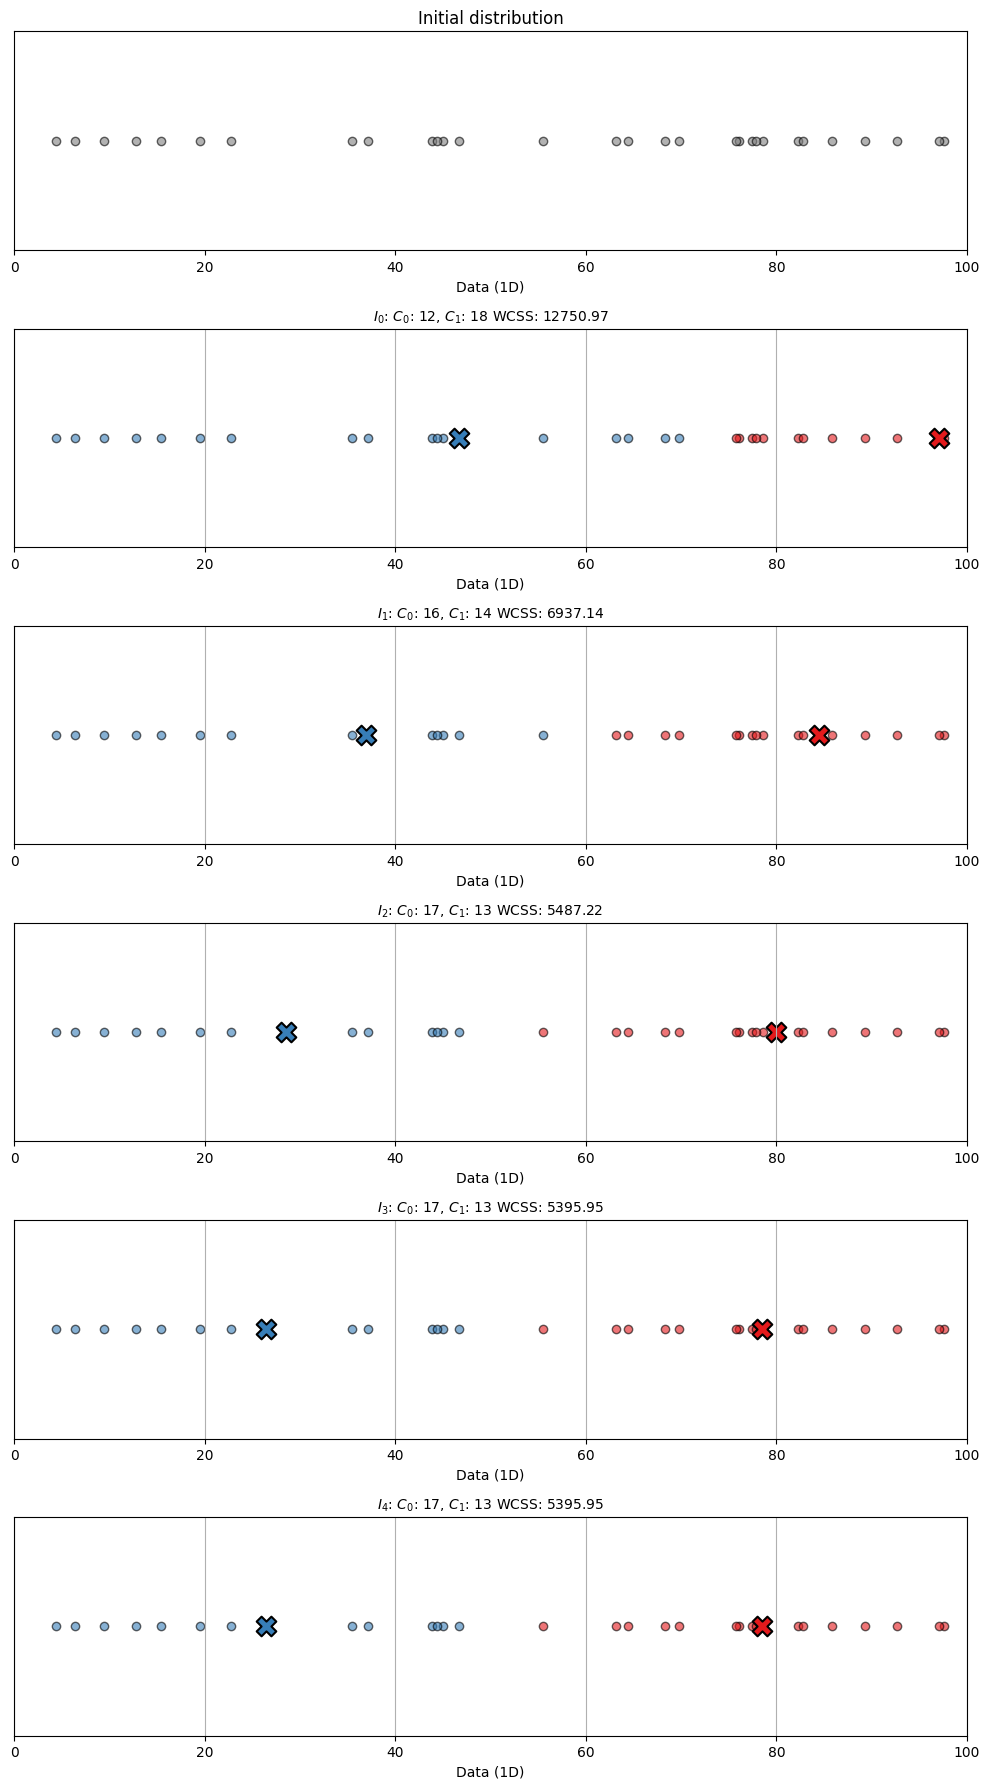

In [9]:
visualize_kmeans_1d(num_points=30, n_clusters=2, max_iters=10, seed=42, max_title_width=60)

Use the following RFM Analysis as an example to demonstrate:

Use different formulaes for customer segmentation for demonstrations.

![](https://i.imgur.com/zCONvnr.png)

# Introduction to Clustering & k-Means


## Introduction: Why Group Things?
Imagine you're a detective trying to organize a massive collection of clues. Clustering is like that, but for data! We're essentially grouping similar data points together to uncover hidden patterns.

* **Clustering:** Think of it as automatic sorting. Like organizing a messy bookshelf into genres.
* **Unsupervised Learning:** We're doing this without any "correct answers" or labels. It's pure exploration!
* **Real-World Example:** Customer segmentation in marketing – grouping customers based on their purchasing habits.

**Activity:** Think of a time you organized something into groups. What criteria did you use?

## k-Means: The "Magnet" Algorithm 🧲

k-Means is a classic clustering algorithm that's simple yet powerful. Imagine you have 'k' magnets, and you scatter them randomly on a table of iron filings.

* **Goal:** To partition data into 'k' distinct clusters. You decide how many groups you want!
* **Steps:**
    1.  **Initialization:** You randomly place 'k' magnets (centroids) on the table.
    2.  **Assignment:** Each iron filing (data point) is attracted to the nearest magnet, forming 'k' clusters.
    3.  **Update:** The magnets move to the center of their respective clusters (the mean of the filings).
    4.  **Iteration:** Repeat steps 2 and 3 until the magnets stop moving (convergence).
 


* **Activity:** Draw a simple scatter plot with a few points and try to visualize how k-Means would cluster them.

    1.  **Initialization:** Randomly select 'k' centroids.
    2.  **Assignment:** Assign data points to nearest centroid.
    3.  **Update:** Recalculate centroids as cluster means.
    4.  **Iteration:** Repeat steps 2 and 3 until convergence.
* **Analogy:** 'k' magnets attracting iron filings.

## The Math Behind the Magnet: Euclidean Distance 📏

To know which magnet (centroid) is closest, we use the Euclidean distance formula:

d=√(x2−x1)2+(y2−y1)2d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}

* $(x_1, y_1)$: Coordinates of your data point.
* $(x_2, y_2)$: Coordinates of a centroid.

**Example:** If your data point is (3, 4) and a centroid is (1, 2), the distance is:

d=√(1−3)2+(2−4)2=√4+4=√8≈2.83d = \sqrt{(1-3)^2 + (2-4)^2} = \sqrt{4 + 4} = \sqrt{8} \approx 2.83

**Activity:** Calculate the Euclidean distance between two points of your choice.

## Analyzing Your Clusters: Are They Meaningful? 🤔

After running k-Means, you need to figure out if your clusters are useful.

* **Cluster Interpretation:**
    * **Visual Inspection:** Plot your clusters! Do they look distinct?
    * **Feature Analysis:** What do the data points in each cluster have in common?
    * **Domain Knowledge:** Does this make sense in your problem's context?
* **Cluster Evaluation:**
    * **Within-Cluster Sum of Squares (WCSS):** How compact are the clusters? Lower is better.
    * **Silhouette Score:** How well does each point fit in its cluster? Higher is better.
    * **Elbow Method:** A trick to find the best 'k'. Plot WCSS vs. 'k' and look for the "elbow" (where the rate of decrease slows down).

**Activity:** Imagine you've clustered customers. What features would you look at to interpret the clusters?

## Practical Example: Iris Dataset Clustering

* We illustrated k-means with a simplified iris dataset.
* We calculated the Euclidean distance between a data point and cluster centroids.
* We assigned the data point to the closest cluster.

### Simplified Iris Data (Example)

| Sepal Length | Petal Length |
| :----------- | :----------- |
| 5.1          | 1.4          |
| 6.3          | 4.9          |
| 7.2          | 6.1          |
| 4.9          | 1.5          |
| 6.8          | 4.8          |
| 5.9          | 5.1          |

### Euclidean Distance Calculations (Example)

* Given data point: (5.1, 1.4)
* Initial centroids: (5, 1), (6, 5), (7, 6)
* Calculations:
    * Distance to (5, 1): $\sqrt{(5.1-5)^2 + (1.4-1)^2} \approx 0.41$
    * Distance to (6, 5): $\sqrt{(5.1-6)^2 + (1.4-5)^2} \approx 3.71$
    * Distance to (7, 6): $\sqrt{(5.1-7)^2 + (1.4-6)^2} \approx 4.98$
* Conclusion: The data point is closest to (5, 1).

Calculate it for every single point and follow the algorithm.


## Choosing the Optimal 'k'

* **Elbow Method:**
    * Plot WCSS (Within-Cluster Sum of Squares) against different values of 'k'.
    * Look for the "elbow" point, where the rate of decrease in WCSS slows down.
    * This point indicates the optimal 'k'.

### Conceptual Elbow Method Plot (Markdown Visualization)

```md
WCSS
^
|
|         *
|       *
|     *
|   *
| *
+------------------> k (Number of Clusters)
```

(The elbow point in this conceptual markdown plot would be around k=3 or 4)

## Evaluating Cluster Quality

* **Silhouette Score:**
    * Measures how well each data point fits within its cluster.
    * Ranges from -1 to 1.
    * Higher values indicate better clustering.

### Silhouette Score Interpretation

* +1: Data point is well-clustered.
* 0: Data point is on or very close to the decision boundary between two neighboring clusters.
* -1: Data point might be assigned to the wrong cluster.

## Practical Considerations

* **Scaling Data:** k-means is sensitive to feature scaling. Scale your data before clustering.
* **Initialization Sensitivity:** k-means can converge to different solutions depending on the initial centroids. Use k-means++ for better initialization.
* **Choosing 'k':** The elbow method is a heuristic. Try different values of 'k' and evaluate the results.
* **Categorical Data:** k-means is designed for numerical data. Convert categorical data to numerical representations if needed.

## k-Means in Python with Scikit-learn

* Scikit-learn provides a simple and efficient implementation of k-Means.

In [10]:
# UTILITY PART : START: DO NOT MODIFY!!!!!!!!!!!!!!!
# FOR OOP: USE A GENERATOR AS LAZY COMPUTATION DOESN'T OVERLOAD

# Create a random number generator
rng = np.random.default_rng()

# Specify the range for x and y coordinates
x_low, x_high = 0, 30  # Range for x (e.g., 0 to 100)
y_low, y_high = 0, 30  # Range for y (e.g., -50 to 50)

# Generate random x and y coordinates
num_points = 100  # Number of coordinates you want
x = rng.uniform(x_low, x_high, num_points)
y = rng.uniform(y_low, y_high, num_points)

# Combine x and y into pairs if needed
coords = list(zip(x, y))

# print("Coordinate pairs:", coords)

# UTILITY PART : END: DO NOT MODIFY!!!!!!!!!!!!!!!

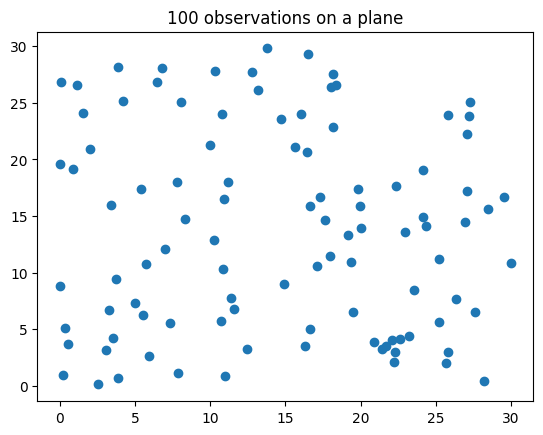

In [11]:
plt.scatter(x,y)
plt.title(f"{num_points} observations on a plane")
plt.show()

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Sample Data
X = np.array(coords)

# Create a KMeans object with 3 clusters
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state=0, n_init = 1)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the cluster centroids
centroids = kmeans.cluster_centers_

print("Cluster Labels:", labels)
print("Cluster Centroids:", centroids)

Cluster Labels: [3 3 2 1 3 0 3 4 1 0 0 0 1 2 1 2 0 1 1 2 0 3 3 2 1 4 2 1 2 3 1 0 1 3 0 1 4
 4 2 3 4 1 2 1 0 1 2 0 1 0 3 3 0 0 0 2 0 0 3 0 1 3 4 1 1 3 2 1 2 4 3 4 2 0
 2 0 2 0 0 0 4 0 2 2 2 4 3 1 1 4 0 4 3 2 4 0 2 2 1 4]
Cluster Centroids: [[ 6.09183171  6.04258381]
 [21.84710827  5.42325204]
 [23.77354664 16.73446732]
 [14.41313347 24.29649105]
 [ 3.6845097  22.98548174]]


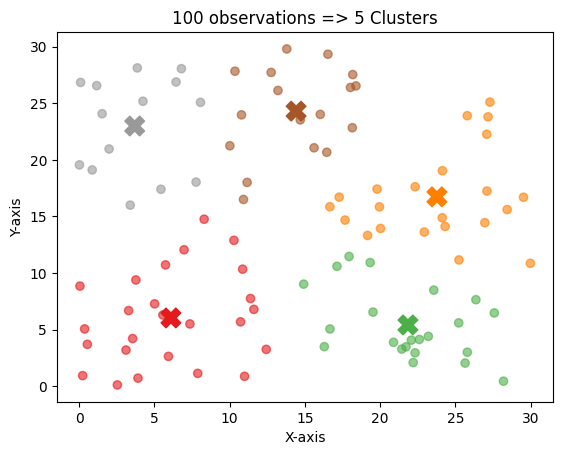

In [13]:
# # Unpacking x,y coordinates of centroids
cluster_i_x, cluster_i_y = zip(*centroids) 

# plt.scatter(x,y, )
# plt.scatter(cluster_i_x, cluster_i_y, c = [_ for _ in range(n_clusters)], cmap = 'Set1')
# plt.title(f"{num_points} observations => {n_clusters} Clusters")
# plt.show()

# Assign cluster labels to each observation in the data
point_colors = kmeans.labels_  # Use the assigned cluster labels for points' colors

# Scatter plot for observations
plt.scatter(x, y, c=point_colors, cmap='Set1', alpha=0.6, label='Observations')

# Scatter plot for centroids
plt.scatter(cluster_i_x, cluster_i_y, c=range(n_clusters), cmap='Set1', marker='X', s=200, label='Centroids')

# Add labels, title, and legend
plt.title(f"{num_points} observations => {n_clusters} Clusters")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
# plt.legend()
plt.show()


In [14]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.4255361808930471


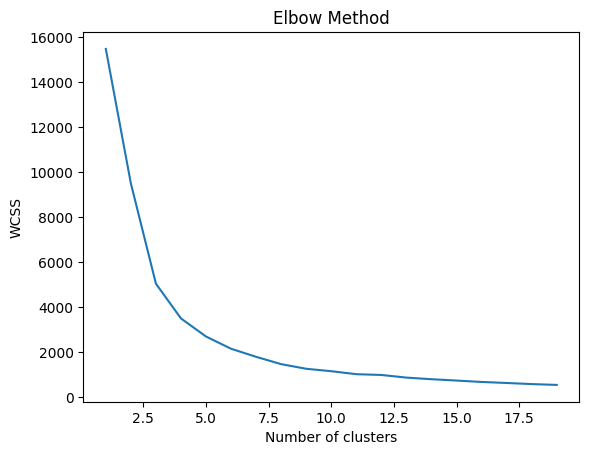

In [15]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Let's see our algorithm in action

### With 2D Observations

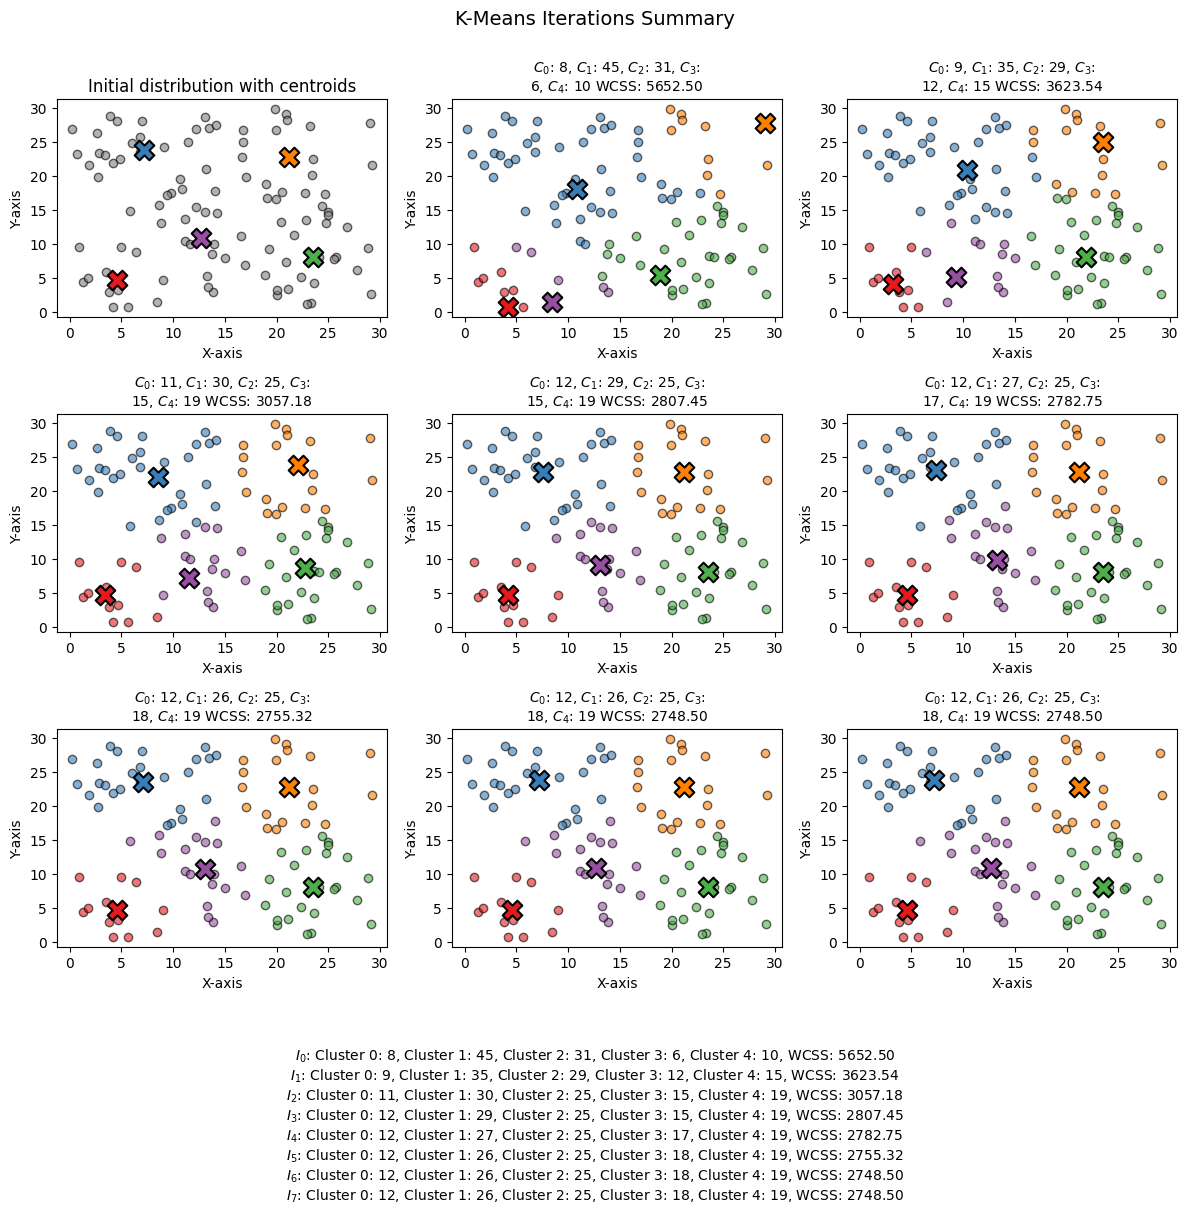

In [16]:
visualize_kmeans_step_by_step(num_points=100, n_clusters=5, max_iters=10, seed=42, max_title_width=40)

Animation saved as kmeans_2d_animation.mp4


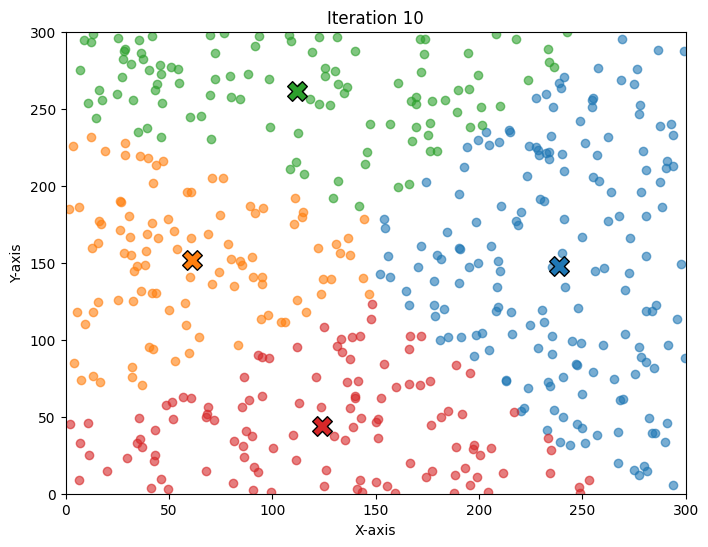

In [17]:
animate_kmeans_2d(num_points=500, n_clusters=4, max_iters=10, seed=42, output_filename="kmeans_2d_animation.mp4", fps=30)

# Video("kmeans_2d_animation.mp4", embed=True)


Animation saved as engaging_kmeans_2d_blobs.mp4


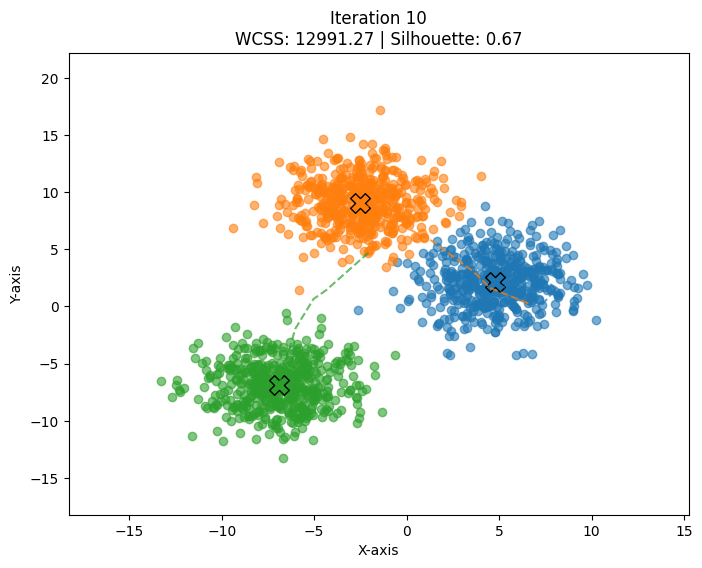

In [18]:
engaging_animate_kmeans_2d(num_points=1500, n_clusters=3, max_iters=25, seed=42, 
                           data_type="blobs", blob_std=2.12, output_filename="engaging_kmeans_2d_blobs.mp4", fps=15)

In [19]:
# Video("engaging_kmeans_2d_blobs.mp4", embed=True)


### Working on 3D Data

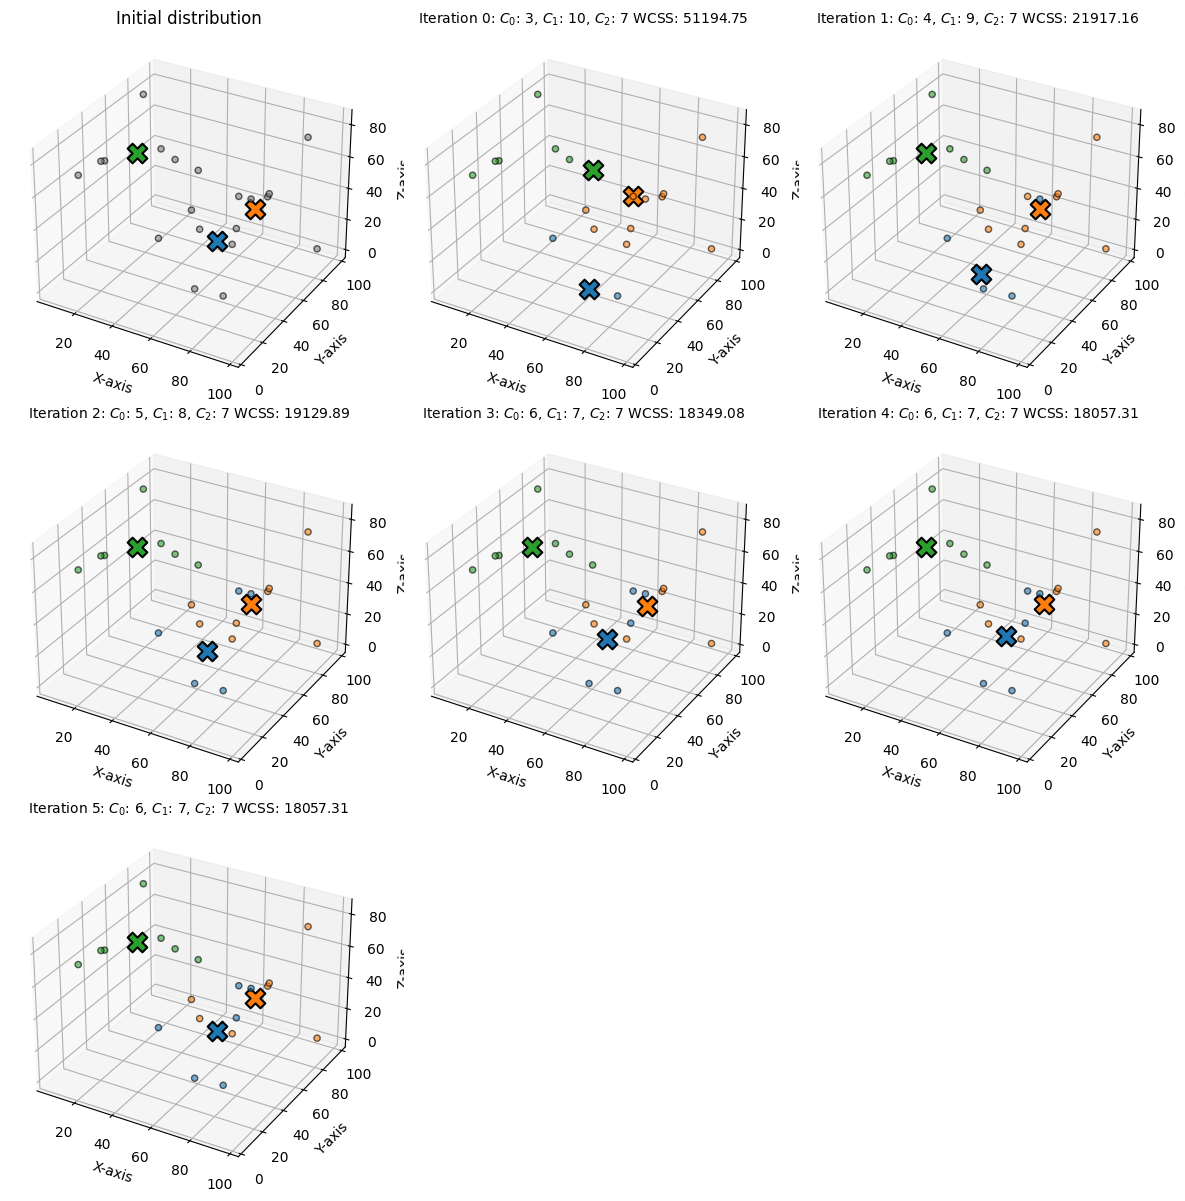

In [20]:
visualize_kmeans_3d(num_points=20, n_clusters=3, max_iters=10, seed=42, max_title_width=60)

Animation saved as kmeans_3d_animation.mp4


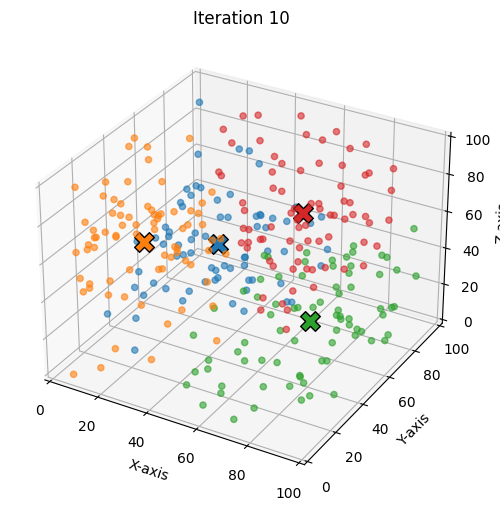

In [21]:
animate_kmeans_3d(num_points=300, n_clusters=4, max_iters=10, seed=42, output_filename="kmeans_3d_animation.mp4")

# Video("kmeans_3d_animation.mp4", embed=True)

In [22]:
create_animated_kmeans_3d(num_points=100, n_clusters=4, max_iters=10, seed=42, data_type="blobs", blob_std=2.5, fps=30)


### Key Takeaways for Hour 1

* Clustering groups similar data.
* k-Means is a popular clustering algorithm.
* Euclidean distance is used to assign data points to clusters.
* Cluster interpretation and evaluation are crucial.
* The elbow method and silhouette score help in evaluation.
* Scikit-learn simplifies k-Means implementation.